In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, \
    precision_recall_curve, auc
from sklearn.preprocessing.label import LabelBinarizer
from models import Classifier, Regression
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase
from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, CVOperator, df_cv_split
from utils import make_plots

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


TODO:
* setup some way of fixing the folds over which cv is done
* combine features from multiple layers with keras models
* try the gifford ensembl model

## Breakpoints

Calculate the breakpoints inside each regulatory element.

In [3]:
breakpoint_df = get_breakpoint_df(df)
# Save breakpoints to CSV
breakpoint_df.to_csv('data/cagi5_bkpt.csv')
# Look at breakpoints
breakpoint_df[breakpoint_df['is_break']!='no'].head(15)

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.93,1.4900,start,NaN,True,0.0
47,X,138612684,G,T,-0.02,0.00,0,release_F9,0.048,-0.233,3.45,-2.0100,end,16.0,False,0.0
48,X,138612701,T,A,-0.36,0.37,-1,release_F9,0.009,0.470,3.27,1.9200,start,NaN,True,1.0
95,X,138612716,G,T,-0.15,0.04,0,release_F9,0.055,0.581,3.32,0.4310,end,16.0,False,1.0
96,X,138612765,C,A,0.07,0.01,0,release_F9,0.420,-0.304,4.22,0.2990,start,NaN,True,2.0
143,X,138612780,T,G,0.18,0.02,0,release_F9,0.525,0.470,4.69,4.6900,end,16.0,False,2.0
144,X,138612877,G,A,-0.09,0.05,0,release_F9,0.864,0.581,5.08,5.0800,start,NaN,True,3.0
190,X,138612892,C,T,0.12,0.01,0,release_F9,0.508,0.581,5.08,1.7900,end,16.0,False,3.0
191,X,138612909,C,A,0.05,0.02,0,release_F9,0.453,0.581,5.08,0.0736,start,NaN,True,4.0
235,X,138612924,A,G,-0.01,0.00,0,release_F9,0.614,0.470,4.55,0.6710,end,16.0,False,4.0


## Cross-validation folds

Split the training data into folds respecting the breakpoints.

In [4]:
nfolds = 5
fold_dict = df_cv_split(breakpoint_df, nfolds)
fold_dict

{'release_F9': [[4], [0], [1], [2], [3]],
 'release_GP1BB': [[2, 4], [5], [0], [3], [1]],
 'release_HBB': [[1], [2], [0], [], []],
 'release_HBG1': [[2], [1], [3], [0], []],
 'release_HNF4A': [[0], [2], [1], [3], []],
 'release_IRF4': [[1, 3], [6, 4], [5, 0], [2], [7]],
 'release_IRF6': [[6, 3], [8, 5], [0, 7], [4, 1], [2]],
 'release_LDLR': [[2], [1], [4], [0], [3]],
 'release_MSMB': [[5, 3], [0, 8], [6, 4], [7, 1], [2]],
 'release_MYCrs6983267': [[8, 4], [3, 0], [7, 2], [1, 5], [6]],
 'release_PKLR': [[2, 3], [6, 5], [1, 7], [4], [0]],
 'release_SORT1': [[1, 6], [2, 7], [3, 0], [5, 8], [4]],
 'release_TERT-GBM': [[2], [1], [4], [0], [3]],
 'release_TERT-HEK293T': [[0], [2], [4], [3], [1]],
 'release_ZFAND3': [[8, 4, 9], [10, 3], [2, 0], [7, 1], [5, 6]]}

## Create features

In [5]:
deepseadiffs = DeepSeaSNP(feattypes=['diff'])
dnase = DNase()
enhancer1hot = EnhancerOneHot()
snpcontext2 = SNPContext(context_size=2)
snpcontext4 = SNPContext(context_size=4)
conservation = Conservation()
deepE1h = MultiFeatures([deepseadiffs, enhancer1hot])

## Logistic regression

Fit a logistic regression classifier to DeepSeaSNP features.

In [6]:
cv_chunk = ChunkCV(df,
                   operator=CVOperator(
                       Classifier,
                       model_kwargs={'features': deepseadiffs, 'model_name': 'lr'}),
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


[-1  0  1]
[0.61808676 0.54935105 0.61831113]


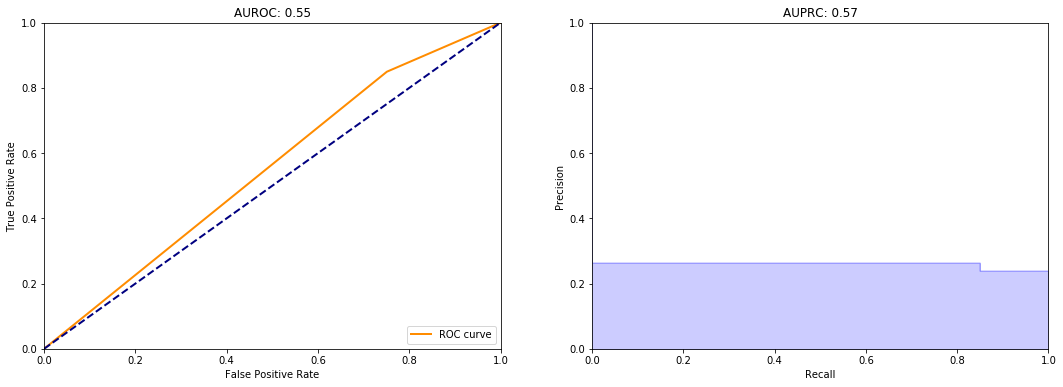

In [7]:
binarizer = LabelBinarizer()
ybin = binarizer.fit_transform(cvdf_chunk['class'])
print(binarizer.classes_)
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

## XGBoost

Cross-validate using XGBoost using a model fit to all regulatory regions but given the one-hot enhancer encodings.

In [8]:
# features = MultiFeatures([deepseadiffs, enhancer1hot, snpcontext4, conservation])
features = deepE1h
cv_chunk = ChunkCV(df,
                   operator=CVOperator(
                       Regression,
                       model_kwargs={'features': features, 'model_name': 'xgb'}),
                   fold_dict=fold_dict)
cv_regress = cv_chunk.get_cv_preds()
cv_regress.sample(6)

Getting predictions for fold 0


XGBoostError: need to call fit beforehand

In [ ]:
cv_regress['Confidence'].abs() > 0.1
_ = make_plots(cv_regress)
print(roc_auc_score(cv_regress['class'].abs(), cv_regress['PredValue'].abs()))

Cross-validate using models fit independently to each regulatory element

In [9]:
# features = MultiFeatures([deepseadiffs, enhancer1hot, snpcontext4, conservation])
import crossval, models, importlib
importlib.reload(crossval)
importlib.reload(models)

<module 'models' from '/home/john/Dev/cagimpra/models.py'>

In [10]:
from crossval import ChunkCV, PerElementOperator, StackedOperator, CVOperator, df_cv_split
from models import MultiFeatures
subst = SubstitutionOneHot()
features = MultiFeatures([deepseadiffs, conservation])
# features = dnase
cv_chunk = ChunkCV(df,
                   operator=StackedOperator(CVOperator(
                       Regression,
                       model_kwargs={'features': features, 'model_name': 'xgb'})),
                   fold_dict=fold_dict)
cv_regress = cv_chunk.get_cv_preds()

Getting predictions for fold 0


XGBoostError: need to call fit beforehand

In [ ]:
cv_regress.to_csv('data/regress.csv')
make_plots(cv_regress)
cv_regress.sample(6)

In [ ]:
cv_chunk = ChunkCV(df,
                   operator=CVOperator(
                       Classifier,
                       model_kwargs={'features': deepseadiffs, 'model_name': 'xgb'}),
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()
cvdf_chunk.sample(6)

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

## Enhancer one-hot

One hot encode the identity of the enhancer.

In [ ]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': enhancer1hot, 'model_name': 'lr'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

In [ ]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': deepE1h, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

In [ ]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': snpcontext2, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

In [ ]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': snpcontext4, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

In [ ]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': conservation, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

In [ ]:
features = MultiFeatures([conservation, snpcontext2, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

In [ ]:
features = MultiFeatures([conservation, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

In [ ]:
features = MultiFeatures([snpcontext2, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
_ = make_plots(cvdf_chunk, 'PredClass')

In [ ]:
cvdf_chunk[['class', 'Value', 'Confidence']].as_matrix()